## Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

#### Notebook destinado a análise de Classificação dos Stacked Autoencoder (SAE)

In [1]:
import sys
import os
import time
import multiprocessing
import pprint 

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

from Packages.NoveltyDetection.setup.noveltyDetectionConfig import CONFIG
from Packages.NoveltyDetection.StackedAutoEncoders.SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis
from Functions.telegrambot import Bot

num_processes = multiprocessing.cpu_count()

my_bot = Bot("lisa_thebot")

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


training_params = {
    "Technique": "StackedAutoEncoder"
}
analysis = SAENoveltyDetectionAnalysis(parameters=training_params, 
#                                        model_hash='d7e9c272a78cd00c3e4ad161fa3cae389c3b2547aff986dd65669d5bceb5f421',
                                       model_hash='3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10',
#                                        model_hash="048afa2017b8b40203db1ef3f94e806a4d9772fe14b032a479f96f9551853574", 
#                                        model_hash='5fee10c0e061666bbd9b5ad4544503a562deb56f25bd5f80b9f2c8ca3bf76b81', # PF linear no decoder
#                                      model_hash='f84a0f006d8a19e5c3dbe25d4907659013495f79bb8b377e88673a899d9e2a2d', # PF tanh no decoder
                                       load_hash=True, load_data=True, verbose=False)
all_data, all_trgt, trgt_sparse = analysis.getData()

SAE = analysis.createSAEModels()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

Using TensorFlow backend.


Reading from /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10/parameters.json
[+] Time to read data file: 1.6473426818847656 seconds
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [2]:
pp = pprint.PrettyPrinter(indent=1)
print(analysis.model_hash)
print(analysis.getBaseResultsPath())
pp.pprint(analysis.parameters)

3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10
/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10
{'DevelopmentEvents': 1600,
 'DevelopmentMode': False,
 'HyperParameters': {'batch_size': 256,
                     'bias_initializer': 'ones',
                     'classifier_loss': 'mean_squared_error',
                     'classifier_output_activation_function': 'softmax',
                     'decoder_activation_function': 'tanh',
                     'dropout': False,
                     'dropout_parameter': 0.0,
                     'encoder_activation_function': 'tanh',
                     'finetuning_n_epochs': 300,
                     'kernel_initializer': 'uniform',
                     'loss': 'mean_squared_error',
                     'metrics': ['accuracy'],
                     'n_folds': 4,
                     'n_inits': 2,
              

### SP Index analysis for a neuron variation at autoencoder

In [ ]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [400,400]

step = 50
neurons_mat = [1] + list(range(step,hidden_neurons[layer-1]+step,step))
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'sp_index_{}_layer_{}'.format(layer, '_'.join(map(str, neurons_mat)))
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# if os.path.exists(analysis_file):
#     os.remove(analysis_file)
    
verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)


results = {}
spIndex = np.zeros([len(analysis.class_labels), analysis.parameters["HyperParameters"]["n_folds"], len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        folds = range(len(analysis.CVO[inovelty]))
        for ifold in folds:    
            train_id, test_id = analysis.CVO[inovelty][ifold]
            class_eff_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"],len(np.unique(all_trgt))])
            known_sp_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"]])

            buff = np.zeros([len(np.unique(all_trgt))-1])
            class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
            known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)

            def getSP(ineuron):

                scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]
                
                classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                           trgt  = analysis.trn_trgt[inovelty], 
                                                           hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                           layer = layer,
                                                           ifold = ifold)

                output = classifier.predict(known_data)
                
                num_known_classes = trn_trgt_sparse[inovelty].shape[1]
                thr_value = 0.3
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff

                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))

                
                return ineuron, sp_index

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            if verbose:
                print('[*] Calculating SP Index ...')
            try:
                results = p.map(getSP, neurons_mat)
                p.close()
                p.join()
                for ineuron_index in range(len(neurons_mat)):
                    spIndex[inovelty, ifold, neurons_mat.index(results[ineuron_index][0])] = results[ineuron_index][1]
            except Exception as e: 
                p.close()
                p.join()          
                print("Erro: {}".format(str(e)))
                break
    joblib.dump([neurons_mat,spIndex],analysis_file,compress=9)
else:
    [neurons_mat, spIndex] = joblib.load(analysis_file)

    
for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    mean_sp = np.mean(spIndex[inovelty,:], axis=0)
    error_sp = np.std(spIndex[inovelty,:,:], axis=0)
    
    ax.plot(neurons_mat, mean_sp, color='b', alpha=0.7, linewidth=2.5, label='Índice SP')
    
    ax.fill_between(neurons_mat, mean_sp+error_sp, mean_sp-error_sp, facecolor='blue', alpha=0.3)
    
    ax.set_title('SAE{} - Índice SP para uma Variação de Neurônios (Classe {} como novidade)'.format(layer,analysis.class_labels[inovelty]),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('Índice SP', fontsize=22)
    ax.set_xlabel('Neurônios', fontsize=22)
    ax.grid()
    ax.legend()
    plt.tight_layout()

    #Save the figure
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons[:layer-1])
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
    plt.savefig(file_name, format="png")
    my_bot.sendMessage(message='SAE{} - Índice SP para uma Variação de Neurônios (Classe {} como novidade)'.format(layer,analysis.class_labels[inovelty]),
                       imgPath=file_name)
    plt.show()

### Figures of Merit for a threshold sweep at output layer

In [ ]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 


inovelty = 0

# Choose neurons topology
# hidden_neurons_total = [400]
# for layer in range(1,len(hidden_neurons_total)+1):
#     hidden_neurons = hidden_neurons_total[:layer]

layer = 1
hidden_neurons = [400]
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons[:layer])
analysis_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# if os.path.exists(analysis_file):
#     os.remove(analysis_file)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (20,15)

if not os.path.exists(analysis_file):
    # Set the threshold to be analyzed
    thr_mat = np.round(np.arange(0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    n_folds = analysis.n_folds

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])

    for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
        for ifold in range(len(analysis.CVO[inovelty])):
            train_id, test_id = analysis.CVO[inovelty][ifold]

            print('Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                    SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                    ifold))
            classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                       trgt  = analysis.trn_trgt[inovelty], 
                                                       hidden_neurons = hidden_neurons[:layer],
                                                       layer = layer,
                                                       ifold = ifold)


            scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
            
            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_target = analysis.trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            known_output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(analysis.all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(analysis.all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = known_output[known_target==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]

                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(known_output,axis=1)>thr_value))/float(len(known_output))

                
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file,compress=9)
else:
    print('file exists')
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=figsize)


sp_auc = np.zeros(len(analysis.getClassLabels()))
acc_auc = np.zeros(len(analysis.getClassLabels()))
trigger_auc = np.zeros(len(analysis.getClassLabels()))
novelty_detection_auc = np.zeros(len(analysis.getClassLabels()))

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Det. Novidade')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Acurácia')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Índice SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Trigger')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='Eficiência Classe {}'.format(analysis.getClassLabels()[iclass]))
    # AUC
    sp_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_sp_mat[:,int(inovelty),:],axis=0))
    acc_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_acc_mat[:,int(inovelty),:],axis=0))
    trigger_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_trig_mat[:,int(inovelty),:],axis=0))
    novelty_detection_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(novelty_eff_mat[:,int(inovelty),:],axis=0))
    
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title("SAE{} - Topologia {} - Classe {} como Novidade".format(layer, neurons_str, analysis.class_labels[inovelty]),
                 fontsize=14, fontweight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])

    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    if inovelty > 1:
        ax.set_xlabel('Limiar',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figuras de Mérito (%)',fontsize=18,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')

    plt.tight_layout()

#Save the figure
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
plt.savefig(file_name, format="png")
try: 
    my_bot.sendMessage(imgPath=file_name)
except Exception as e:
    print("Error when sending the image to the bot. Error: {}".format(str(e)))

### AUC Analysis

In [ ]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 
# layer = 2

inovelty = 3

# Choose neurons topology
hidden_neurons_total = [400,350,300,250,200,150,100,50]

layers = [1,2,3,4,5,6,7,8]

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w',]
m_markers = ['^', 's', 'o', 'p']

figsize = (10,7)


fig = plt.subplots(figsize=figsize)

ax = plt.subplot(1,1,1)

i = 0
for layer in layers:
    hidden_neurons = hidden_neurons_total[:layer]
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    analysis_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
    analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

    verbose = True

    if not os.path.exists(analysis_file):
        # Set the threshold to be analyzed
        thr_mat = np.round(np.arange(0.0,1.05,0.05),3)
        thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

        n_folds = analysis.n_folds

        class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
        novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])

        for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
            for ifold in range(len(analysis.CVO[inovelty])):
                train_id, test_id = analysis.CVO[inovelty][ifold]

                print 'Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                        SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                        ifold)
                classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                           trgt  = analysis.trn_trgt[inovelty], 
                                                           hidden_neurons = hidden_neurons[:layer],
                                                           layer = layer,
                                                           ifold = ifold)

                
                scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]

                novelty_data = scaler.transform(all_data[all_trgt==inovelty])

                output = classifier.predict(known_data)
                novelty_output = classifier.predict(novelty_data)
                class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat = analysis.get_figures_of_merit(known_output=output,
                                                                                                                                     known_target=known_trgt, 
                                                                                                                                     novelty_output=novelty_output,
                                                                                                                                     thr_mat=thr_mat, 
                                                                                                                                     inovelty=inovelty,
                                                                                                                                     ifold=ifold)
        joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                    analysis_file,compress=9)
    else:
        print 'file exists'
        [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

    ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(inovelty),:],axis=0),
                np.std(novelty_eff_mat[:,int(inovelty),:],axis=0),fmt='{}-'.format(m_markers[0]),
                color=m_colors[i], alpha=0.7, linewidth=4,
                label=u'N.D. (SAE{})'.format(layer))
    ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(inovelty),:],axis=0),
                np.std(known_sp_mat[:,int(inovelty),:],axis=0),fmt='{}:'.format(m_markers[1]),
                color=m_colors[i], alpha=0.7, linewidth=4,
                label='SP (SAE{})'.format(layer))

    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title("SAE - Class {} as Novelty".format(analysis.class_labels[inovelty]),
                 fontsize=16, fontweight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])

    ax.set_ylim([0.0, 1.45])
    y_ticks = np.arange(0.0,1.2,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    ax.set_ylabel(u'Figures-of-Merit (%)',fontsize=18,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3,loc='upper center')

    plt.tight_layout()
    i = i + 1
#Save the figure
analysis_name = "figures_of_merit_multiple_layers".format(layer,neurons_str)
file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty.png".format(inovelty))
plt.savefig(file_name, format="png")
try: 
    my_bot.sendMessage(imgPath=file_name)
except Exception as e:
    print("Error when sending the image to the bot. Error: {}".format(str(e)))

In [ ]:
# Thresolds variation x Figures of Merit
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from keras.utils import to_categorical

analysis_name = "fine_tuning_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

if os.path.exists(analysis_file):
    results = pd.read_csv(analysis_file)
else: 
    columns = [
               'layers', 'topology',
               'novelty_class', 'fold',
               'threshold', 'sp_index',
               'accuracy', 'recall',
               'precision', 'f1_score',
               'trigger', 'novelty_detection',
               'efficiency_A', 
               'efficiency_B', 
               'efficiency_C',
               'efficiency_D'
              ]
    results = pd.DataFrame(columns=columns)

# Choose neurons topology
hidden_neurons_total = [400,350,300,250,200,150,100,50]

layers = [1]
layer = 7

# Set the threshold to be analyzed
if analysis.parameters['HyperParameters']['classifier_output_activation_function'] == 'tanh':
    thr_min = -1
else: 
    thr_min = 0    
thr_mat = np.round(np.arange(thr_min,1.05,0.05),3)
thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

n_folds = analysis.n_folds

neurons_mat = [1] + list(range(50,150,50))

for ineuron in neurons_mat:
    hidden_neurons = [400,350,300,250,200,150,100,ineuron]
    neurons_str = SAE[0].get_neurons_str(trn_data[0],hidden_neurons=hidden_neurons)  

    verbose = True

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
        for ifold in range(len(analysis.CVO[inovelty])):
            train_id, test_id = analysis.CVO[inovelty][ifold]

            print('Novelty class: {} - Topology: {} - Fold {}'.format(analysis.class_labels[inovelty],
                                                                      SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                      ifold
                                                                     )
                 )
            # Load Model
            classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty], trgt  = analysis.trn_trgt[inovelty], hidden_neurons = hidden_neurons[:layer], layer = layer, ifold = ifold)


            scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_target = analysis.trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            # Get outputs
            known_output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            # Sweep threshold at output layer
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(analysis.all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(analysis.all_trgt)):
                    if iclass == inovelty:
                        continue
                    # y_pred
                    output_of_class_events = known_output[known_target==iclass-(iclass>inovelty),:]
                    # Use winner takes all
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]

                # Get results
                acc = np.mean(buff,axis=0)
                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))

                y_pred_above_thr = np.argmax(known_output[known_output.max(axis=1)>=thr_value], axis=1)
                y_true_above_thr = known_target[known_output.max(axis=1)>=thr_value]
                if len(y_pred_above_thr)!=0 and len(y_true_above_thr)!=0:
                    recall = metrics.recall_score(y_true_above_thr, y_pred_above_thr, average='macro')
                    precision = metrics.precision_score(y_true_above_thr, y_pred_above_thr, average='macro')
                    f1_score =metrics.f1_score(y_true_above_thr, y_pred_above_thr, average='macro')
                else: 
                    recall = 0
                    precision = 0
                    f1_score = 0
                    
                trigger = float(sum(np.max(known_output,axis=1)>thr_value))/float(len(known_output))
                novelty_detection = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))

                # Append to dataframe
                result = {
                            'novelty_class': analysis.getClassLabels()[inovelty],
                            'layers': layer, 
                            'topology': neurons_str,
                            'threshold': thr_value,
                            'fold': ifold,
                            'sp_index': sp_index,
                            'accuracy': acc,
                            'recall': recall,
                            'precision': precision,
                            'f1_score': f1_score,
                            'trigger': trigger,
                            'novelty_detection': novelty_detection,
                            'efficiency_A': class_eff_mat[ifold, inovelty, 0, ithr], 
                            'efficiency_B': class_eff_mat[ifold, inovelty, 1, ithr], 
                            'efficiency_C': class_eff_mat[ifold, inovelty, 2, ithr],
                            'efficiency_D': class_eff_mat[ifold, inovelty, 3, ithr]
                }

                results = results.append(result, ignore_index=True)
# Save results
results.drop_duplicates(inplace=True, keep='last')
results.to_csv(analysis_file,index=False)

Novelty class: A - Topology: 400x400x350x300x250x200x150x100x1x3 - Fold 0
[-] Error: File or Directory not found. Path: /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10/classifier_model_0_novelty_400x400x350x300x250x200x150x100_neurons_fold_0_model.h5
Classifier - Layer: 7 - Topology: 400x400x350x300x250x200x150x100 - Fold: 1 of 4 Folds -  Init: 1 of 2 Inits
Classifier - Layer: 7 - Topology: 400x400x350x300x250x200x150x100 - Fold: 1 of 4 Folds -  Init: 2 of 2 Inits
Novelty class: A - Topology: 400x400x350x300x250x200x150x100x1x3 - Fold 1
[-] Error: File or Directory not found. Path: /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/outputs/3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10/classifier_model_0_novelty_400x400x350x300x250x200x150x100_neurons_fold_1_model.h5
Classifier - Layer: 7 - Topology: 400x400x35

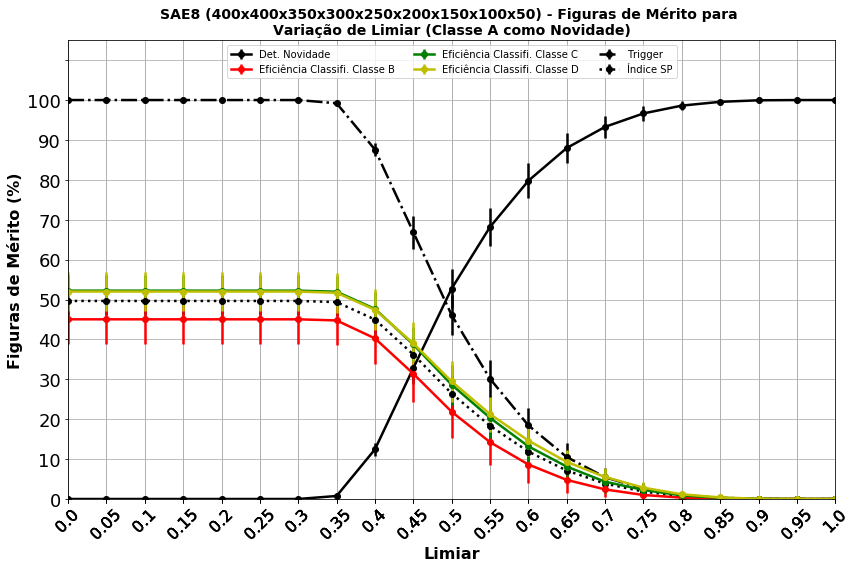

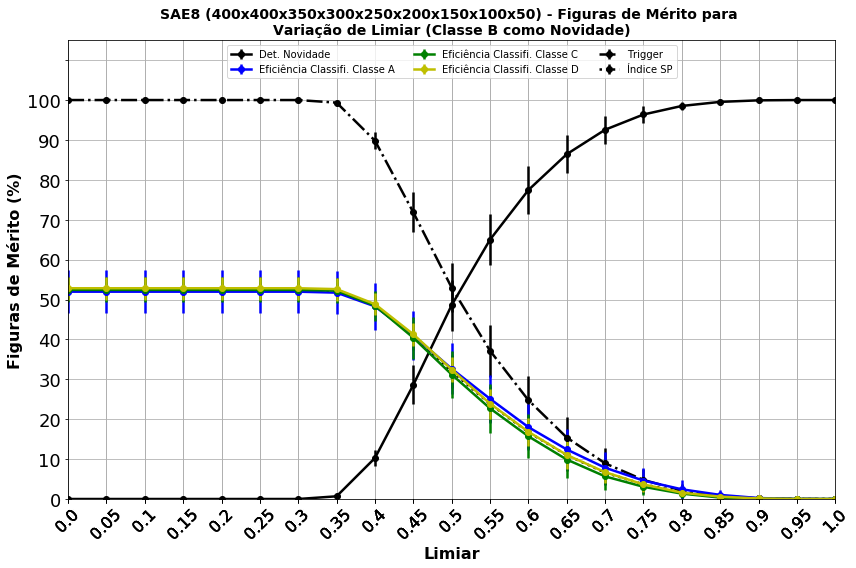

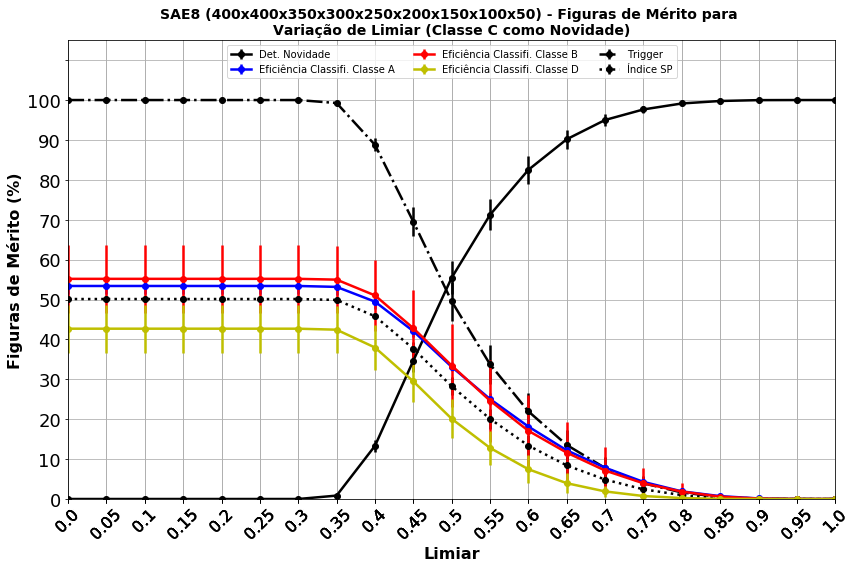

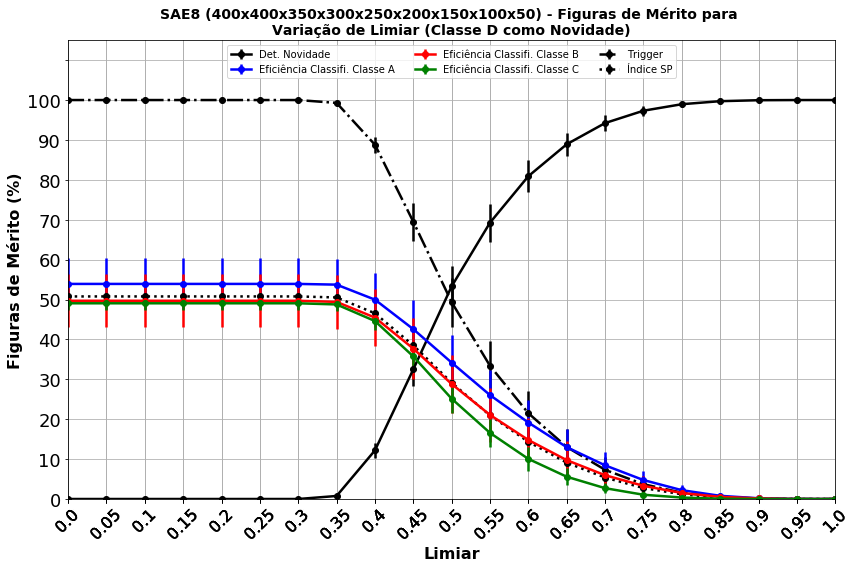

In [24]:
import pandas as pd

analysis_name = "fine_tuning_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

if os.path.exists(analysis_file):
    results = pd.read_csv(analysis_file)
    layer = 8
    neurons_mat = [50]
    for ineuron in neurons_mat:
        neurons_str = '400x400x350x300x250x200x150x100x{}'.format(ineuron)
        for inovelty in range(len(analysis.getClassLabels())):
            results_plot = results.query("novelty_class == '{0}' & layers == {1} & topology == '{2}'".format(analysis.getClassLabels()[inovelty], layer, neurons_str))
            language = 'portuguese'
            labels_text = {
                    'portuguese': {
                        'threshold': 'Limiar',
                        'sp_index': 'Índice SP',
                        'trigger': 'Trigger',
                        'novelty_detection': 'Det. Novidade',
                        'efficiency_A': 'Eficiência Classifi. Classe A', 
                        'efficiency_B': 'Eficiência Classifi. Classe B', 
                        'efficiency_C': 'Eficiência Classifi. Classe C',
                        'efficiency_D': 'Eficiência Classifi. Classe D'
                    },
                    'english': {
                        'threshold': 'Threshold',
                        'sp_index': 'SP Index',
                        'trigger': 'Trigger',
                        'novelty_detection': 'Novelty Detection',
                        'efficiency_A': 'Efficiency Class A', 
                        'efficiency_B': 'Efficiency Class B', 
                        'efficiency_C': 'Efficiency Class C',
                        'efficiency_D': 'Efficiency Class D'
                    }
            }
        
            plot_title = {
                'portuguese': 'SAE{0} ({2}) - Figuras de Mérito para \nVariação de Limiar (Classe {1} como Novidade)',
                'english': 'SAE{0} ({2}) - Figures-of-Merit for a Threshold Variation (Class {1} as Novelty)'
            }

            plot_axes_labels = {
                'portuguese': {
                    'x': 'Limiar',
                    'y': u'Figuras de Mérito (%)'
                },
                'english': {
                    'x': 'Threshold',
                    'y': 'Figures-of-Merit (%)'
                }
            }
    
            style = { 
                labels_text[language]['novelty_detection']: 'ko-',
                labels_text[language]['sp_index']: 'ko:',
                labels_text[language]['trigger']: 'ko-.',  
                labels_text[language]['efficiency_A']: 'bo-',  
                labels_text[language]['efficiency_B']: 'ro-',  
                labels_text[language]['efficiency_C']: 'go-',  
                labels_text[language]['efficiency_D']: 'yo-',         
            }
        
            eff = ['efficiency_A', 'efficiency_B', 'efficiency_C', 'efficiency_D']    
            eff.remove('efficiency_{}'.format(analysis.getClassLabels()[inovelty]))
            columns_to_plot = ['fold', 'threshold', 'sp_index', 'trigger', 'novelty_detection'] + eff

            results_plot = results_plot[columns_to_plot]
            
            data = results_plot.groupby(['threshold']).mean().drop(columns=['fold']).rename(columns=labels_text[language])
            
            ###########################################################################
            ax = data.plot(y=labels_text[language]['sp_index'],
                           figsize=(12,8),
                           lw=2.5,
                           fmt=style[labels_text[language]['sp_index']],
                           yerr=results_plot.groupby(['threshold']).std().rename(columns=labels_text[language])
                           )
            data.plot(ax=ax,
                      y=labels_text[language]['trigger'],
                      lw=2.5,
                      fmt=style[labels_text[language]['trigger']],
                      yerr=results_plot.groupby(['threshold']).std().rename(columns=labels_text[language])
                      )
            data.plot(ax=ax,
                      y=labels_text[language]['novelty_detection'],
                      lw=2.5,
                      fmt=style[labels_text[language]['novelty_detection']],
                      yerr=results_plot.groupby(['threshold']).std().rename(columns=labels_text[language])
                      )
            for i in eff:
                data.plot(ax=ax,
                          y=labels_text[language][i],
                          lw=2.5,
                          fmt=style[labels_text[language][i]],
                          yerr=results_plot.groupby(['threshold']).std().rename(columns=labels_text[language])
                          )
            ##################################################################################################
            
            ax.set_title(plot_title[language].format(layer, analysis.class_labels[inovelty], neurons_str),
                             fontsize=14, fontweight='bold')
            ax.set_xlim([results_plot['threshold'].min(), results_plot['threshold'].max()])
            ax.set_xticks(results_plot['threshold'])
            ax.set_xticklabels(results_plot['threshold'],rotation=45, fontsize=16)


            ax.set_ylim([0.0, 1.15])
            y_ticks = np.arange(0.0,1.2,0.1)
            ax.set_yticks(y_ticks)
            y_tick_labels = 100*y_ticks[y_ticks<=1.0]
            y_tick_labels = y_tick_labels.astype(int)
            ax.set_yticklabels(y_tick_labels,fontsize=18)

            ax.grid()

            ax.set_xlabel(plot_axes_labels[language]['x'],fontsize=16,weight='bold')
            ax.set_ylabel(plot_axes_labels[language]['y'],fontsize=16,weight='bold')

            handles, labels = ax.get_legend_handles_labels()
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
            ax.legend(handles, labels, ncol=3, loc='upper center')

            plt.tight_layout()

            #Save the figure
            figure_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
            file_name = os.path.join(analysis.pictures_output_folder, figure_name+"_novelty_class_{}.png".format(analysis.class_labels[inovelty]))
            plt.savefig(file_name, format="png")
            plt.show()
            try: 
                my_bot.sendMessage(message=plot_title[language].format(layer, analysis.class_labels[inovelty], neurons_str), imgPath=file_name)
            except Exception as e:
                print("Error when sending the image to the bot. Error: {}".format(str(e)))

In [51]:
df_grouped = results.query("layers == 4 and novelty_class=='C'").groupby(['threshold'])
'' + df_grouped.mean().drop(columns=['fold']).astype(str) + ' +/- ' + df_grouped.std().drop(columns=['fold']).astype(str)

,layers,sp_index,accuracy,recall,precision,f1_score,trigger,novelty_detection,efficiency_A,efficiency_B,efficiency_C,efficiency_D
threshold,,,,,,,,,,,,
0.00,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.05,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.10,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.15,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.20,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.25,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.30,4.0 +/- 0.0,0.6448737258456188 +/- 0.23160112464060026,0.682161676335838 +/- 0.14250067754880136,0.682161676335838 +/- 0.14250067754880136,0.6738201431643113 +/- 0.16916663446561062,0.6713967015077581 +/- 0.16436998357465155,1.0 +/- 0.0,0.0 +/- 0.0,0.7179992602110347 +/- 0.22676963022278782,0.7243312697114824 +/- 0.11258334090760608,0.0 +/- 0.0,0.6041544990849977 +/- 0.18365204778546498
0.35,4.0 +/- 0.0,0.6295773505269274 +/- 0.26385210822714716,0.6425651208970916 +/- 0.23953013410507984,0.6836986950040302 +/- 0.13959669890434748,0.6710086814556158 +/- 0.1760734514312238,0.6687768343613467 +/- 0.17207800622777247,0.8864699736531297 +/- 0.28850769238309976,0.11491794182922559 +/- 0.28902084500254605,0.6882908928084726 +/- 0.27755431992808305,0.6703948136899893 +/- 0.234214285922177,0.0 +/- 0.0,0.5690096561928124 +/- 0.23358456047557305
0.40,4.0 +/- 0.0,0.625262704807075 +/- 0.26336351022345267,0.6278082778491607 +/- 0.2638316124899574,0.6832727939722355 +/- 0.21702148085693113,0.6846221451847683 +/- 0.2190532623313481,0.677628678998504 +/- 0.22470246546922173,0.8465132577969865 +/- 0.3512963399308946,0.16687229879686946 +/- 0.34582969642139727,0.6797589845423043 +/- 0.2895906750367466,0.6464344118677723 +/- 0.2777759304924153,0.0 +/- 0.0,0.557231437137406 +/- 0.24578581535917818


### AUC analysis of Figures-of-Merit

TypeError: Empty 'DataFrame': no numeric data to plot

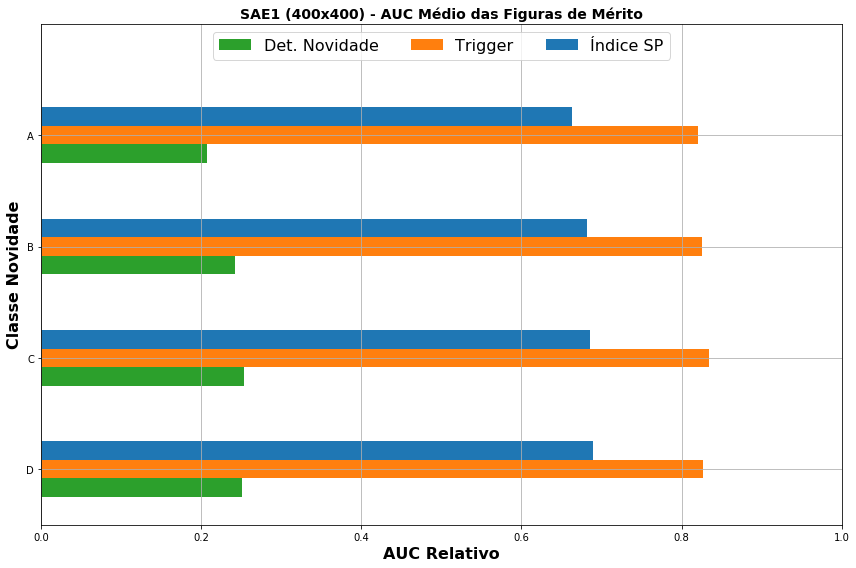

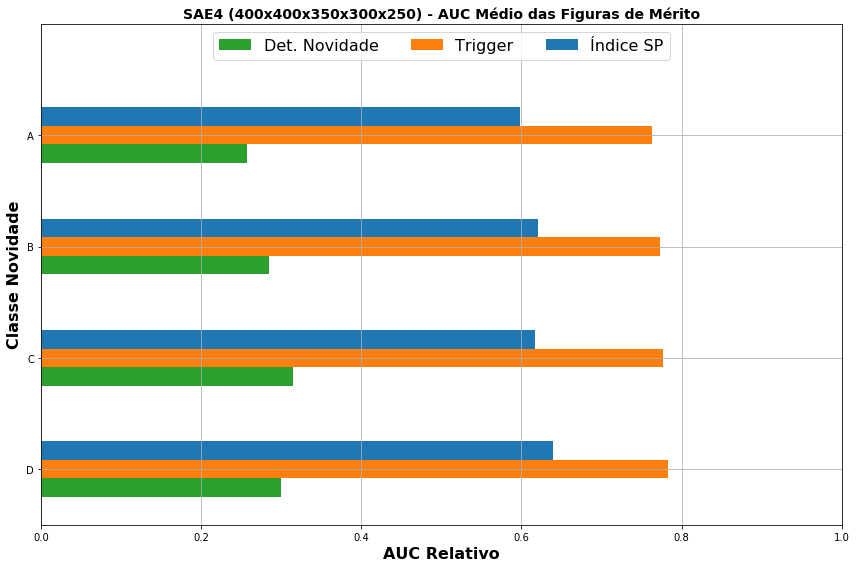

In [8]:
import pandas as pd

analysis_name = "fine_tuning_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

if os.path.exists(analysis_file):
    results = pd.read_csv(analysis_file)
    neurons_mat = [1] + list(range(50,450,50))
    # neurons_mat = [400]

    for layer in [1,4,8]:
        hidden_neurons = range(400,0,-50)
        neurons_str = SAE[0].get_neurons_str(trn_data[0],hidden_neurons=hidden_neurons[:layer])
        language = 'portuguese'
        labels_text = {
                'portuguese': {
                    'threshold': 'Limiar',
                    'sp_index': 'Índice SP',
                    'accuracy': 'Acurácia',
                    'trigger': 'Trigger',
                    'novelty_detection': 'Det. Novidade',
                    'efficiency_A': 'Eficiência Classifi. Classe A', 
                    'efficiency_B': 'Eficiência Classifi. Classe B', 
                    'efficiency_C': 'Eficiência Classifi. Classe C',
                    'efficiency_D': 'Eficiência Classifi. Classe D'
                },
                'english': {
                    'threshold': 'Threshold',
                    'sp_index': 'SP Index',
                    'accuracy': 'Accuracy',
                    'trigger': 'Trigger',
                    'novelty_detection': 'Novelty Detection',
                    'efficiency_A': 'Efficiency Class A', 
                    'efficiency_B': 'Efficiency Class B', 
                    'efficiency_C': 'Efficiency Class C',
                    'efficiency_D': 'Efficiency Class D'
                }
        }

        plot_title = {
            'portuguese': 'SAE{0} ({1}) - AUC Médio das Figuras de Mérito',
            'english': 'SAE{0} ({1})- Mean AUC of Figures-of-Merit'
        }

        plot_axes_labels = {
            'portuguese': {
                'x': 'AUC Relativo',
                'y': 'Classe Novidade'
            },
            'english': {
                'x': 'Relatiev AUC',
                'y': 'Novelty Class'
            }
        }


        results_plot = results.query("layers == {0} & topology == '{1}'".format(layer, neurons_str))
        thr_mat = results_plot['threshold'].unique()

        def get_auc(x):
            return analysis.relative_auc(thr_mat, x)

        columns_plot_auc = ['sp_index', 'trigger', 'novelty_detection']
        results_auc = pd.DataFrame(columns=columns_plot_auc)

        for novelty_class in results_plot['novelty_class'].unique():
            series = results_plot.query("novelty_class == '{}'".format(novelty_class)).groupby(['threshold'])
            series = series.mean().drop(columns=['fold'])[columns_plot_auc]
            series = series.apply(get_auc).rename(novelty_class)
            results_auc = results_auc.append(series)

        ax = results_auc.rename(columns=labels_text[language]).plot(figsize=(12,8), kind='barh')

        ax.set_title(plot_title[language].format(layer, neurons_str),
                    fontsize=14, fontweight='bold')

        #ax.set_yticklabels(["Classe {}".format(ilabel) for ilabel in analysis.getClassLabels()])
        ax.set_ylim((-1,3.5))
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlim((0,1))

        ax.grid()

        ax.set_xlabel(plot_axes_labels[language]['x'],fontsize=16,weight='bold')
        ax.set_ylabel(plot_axes_labels[language]['y'],fontsize=16,weight='bold')

        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, ncol=3, loc='upper center', fontsize=16)

        plt.tight_layout()

        #Save the figure
        figure_name = "auc_figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
        file_name = os.path.join(analysis.pictures_output_folder, figure_name+".png")
        plt.savefig(file_name, format="png")
        try: 
            my_bot.sendMessage(message=plot_title[language].format(layer, neurons_str), imgPath=file_name)
        except Exception as e:
            print("Error when sending the image to the bot. Error: {}".format(str(e)))

### Receiver Operating Characteristic (ROC) Curve for SP/Trigger with Novelty Detection

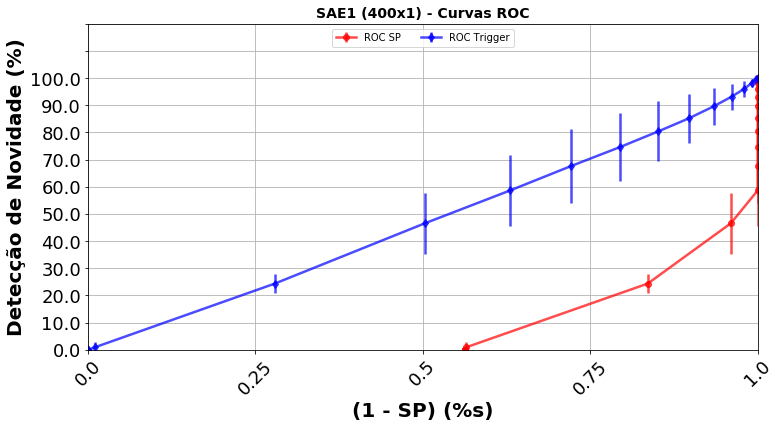

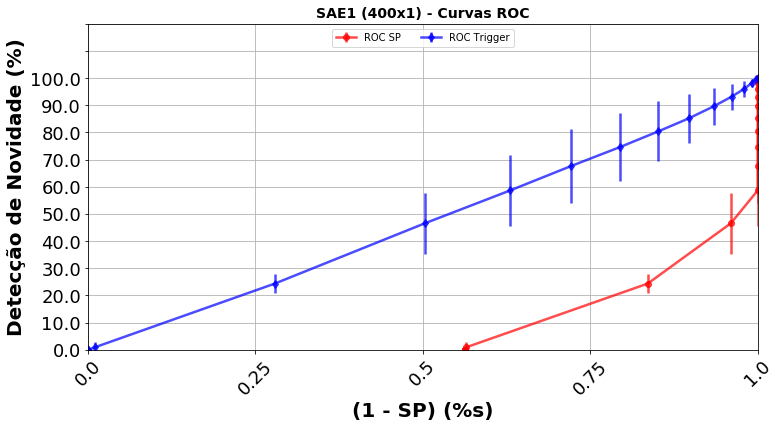

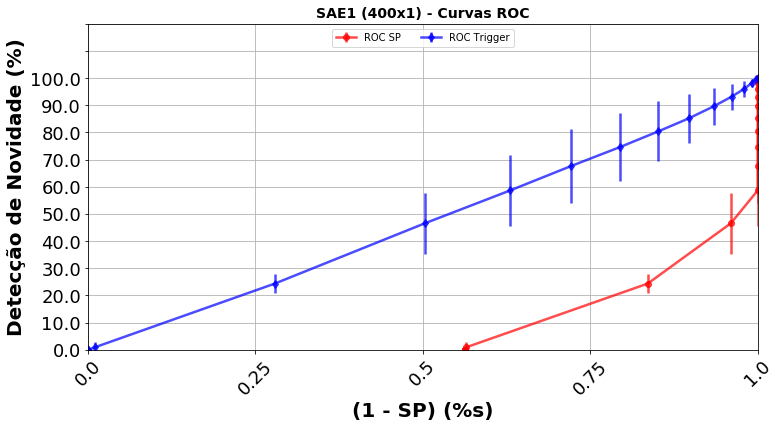

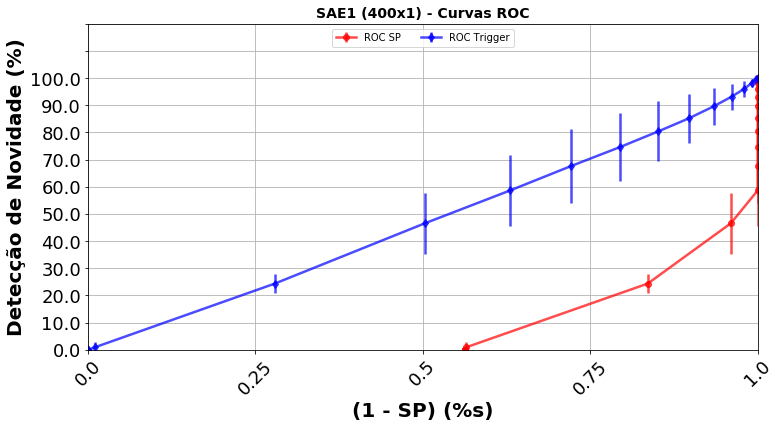

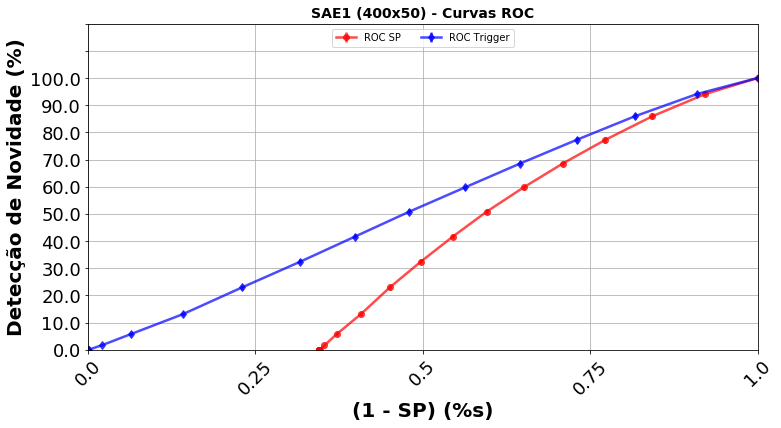

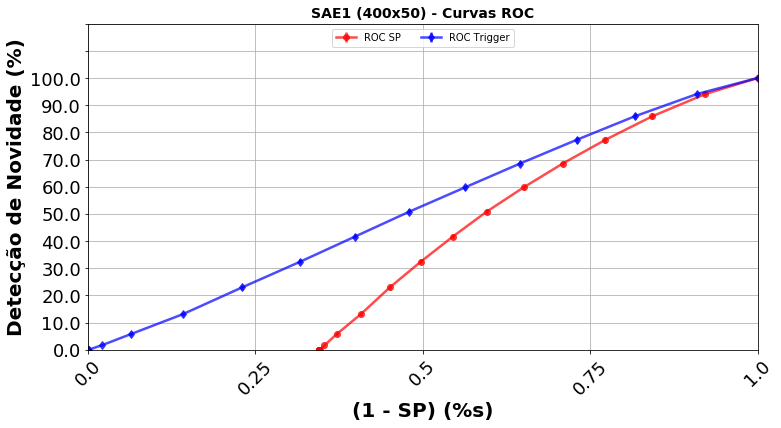

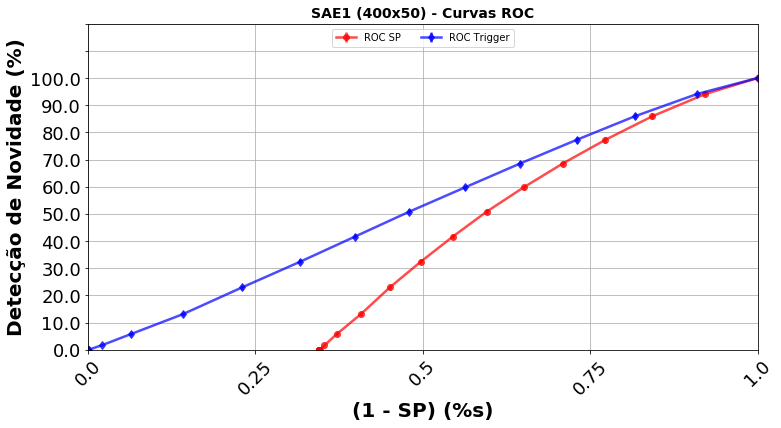

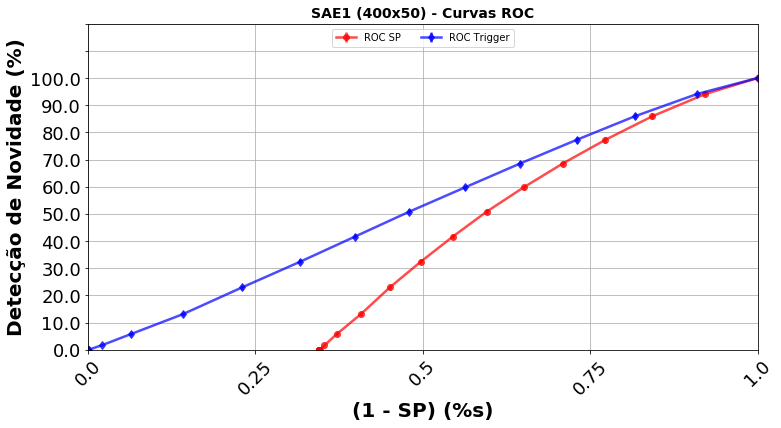

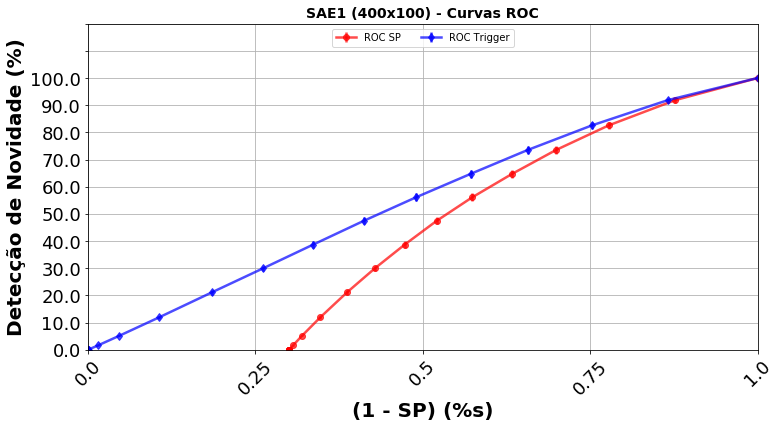

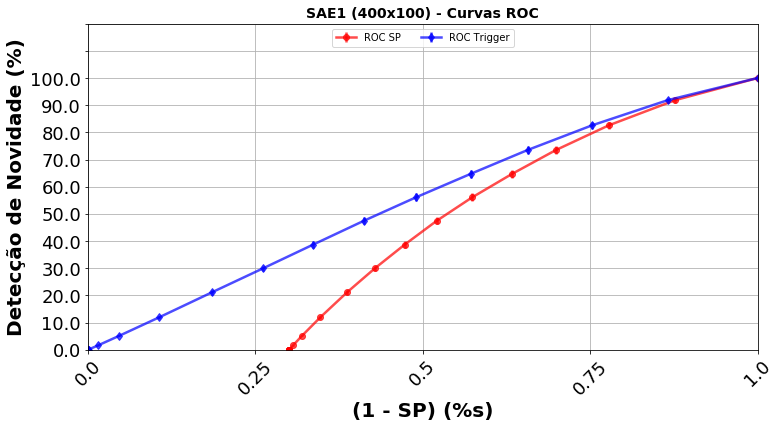

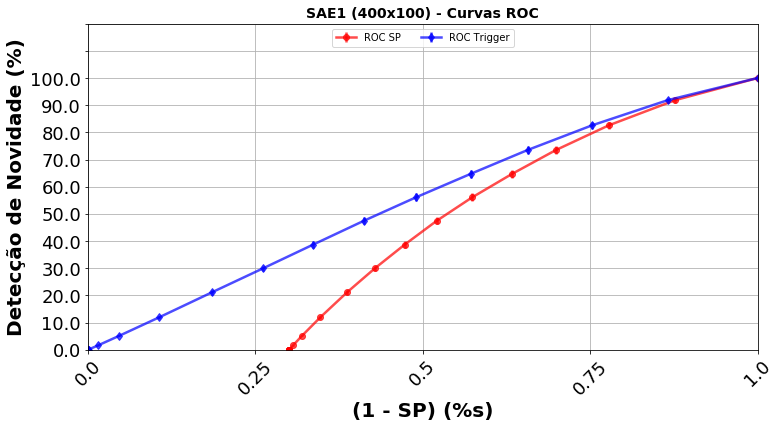

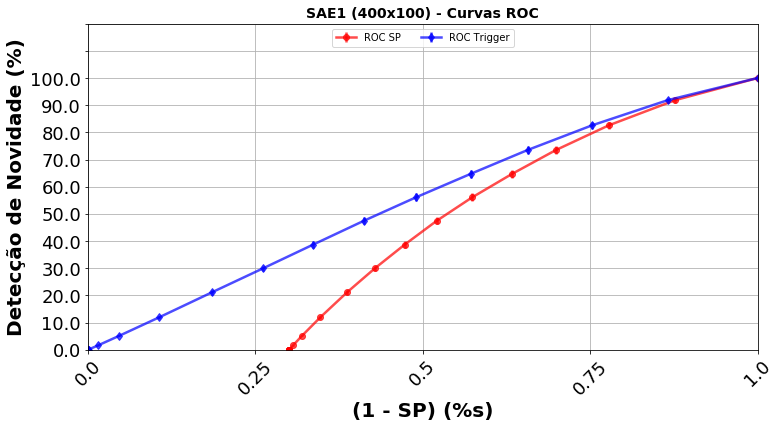

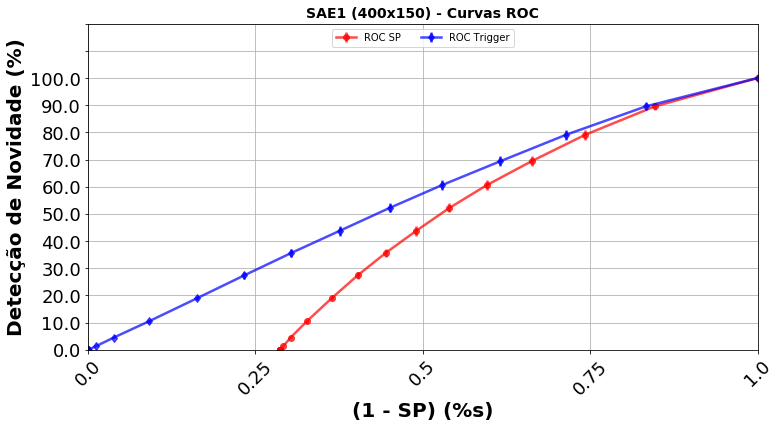

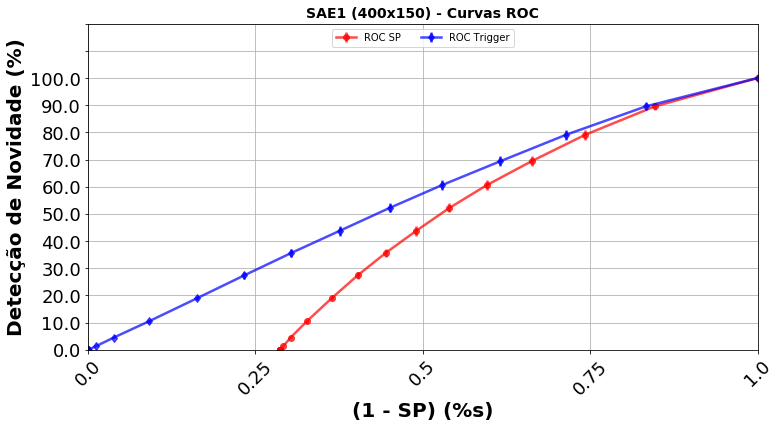

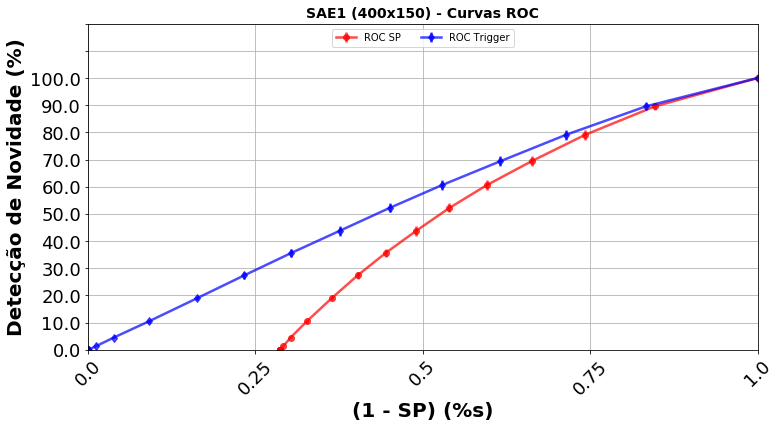

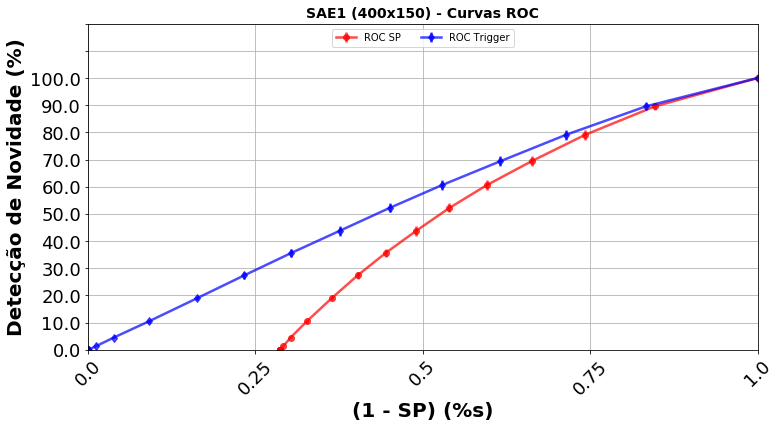

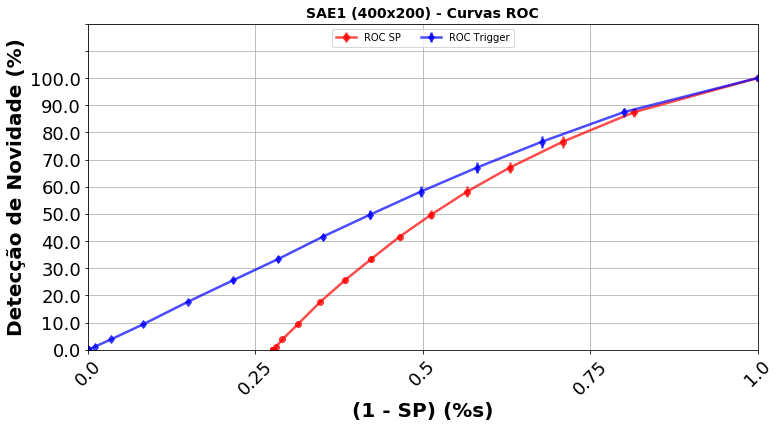

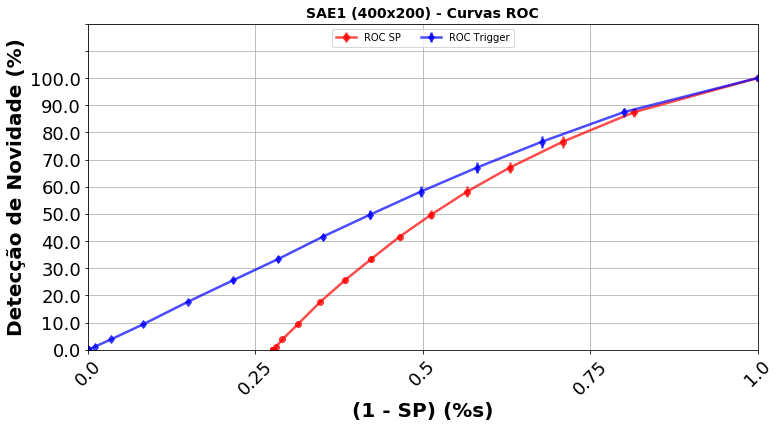

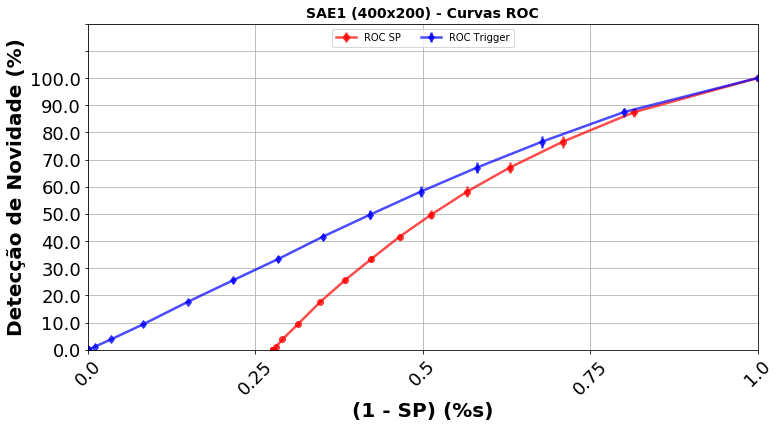

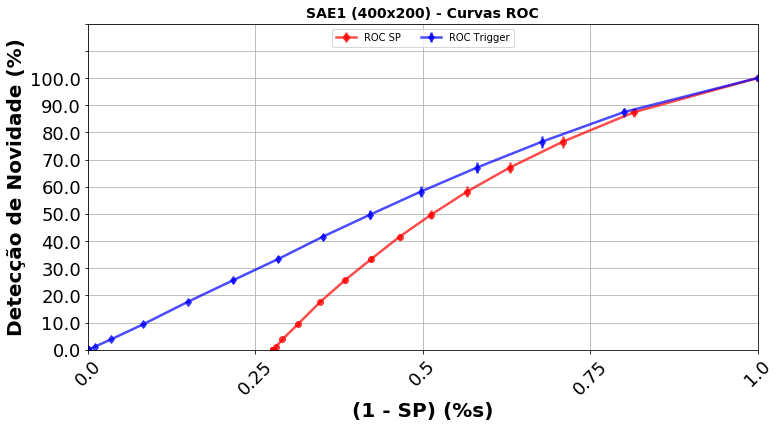

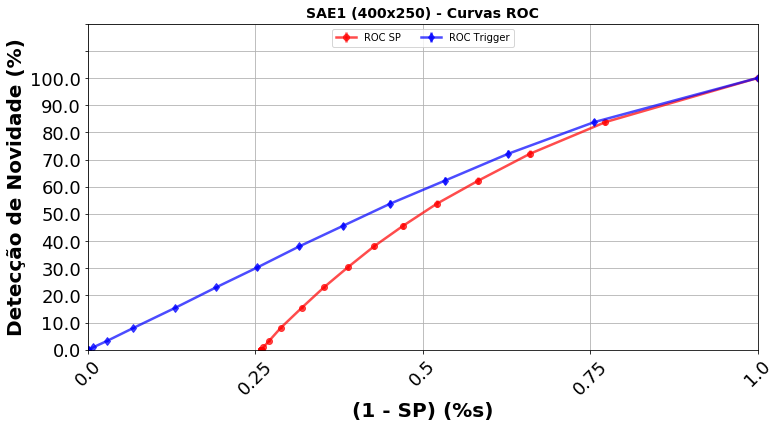

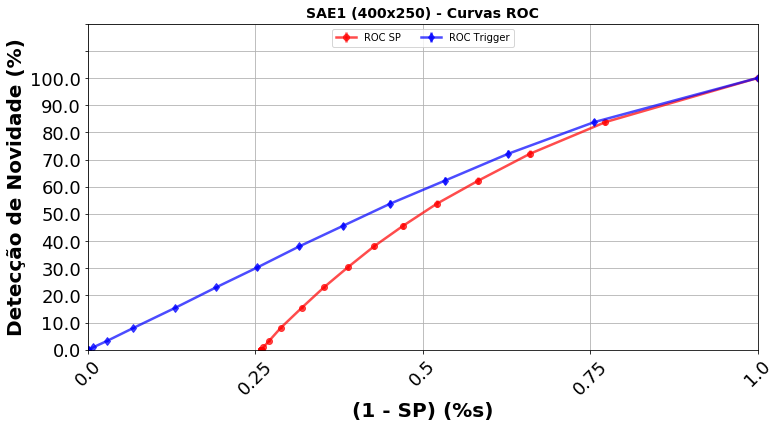

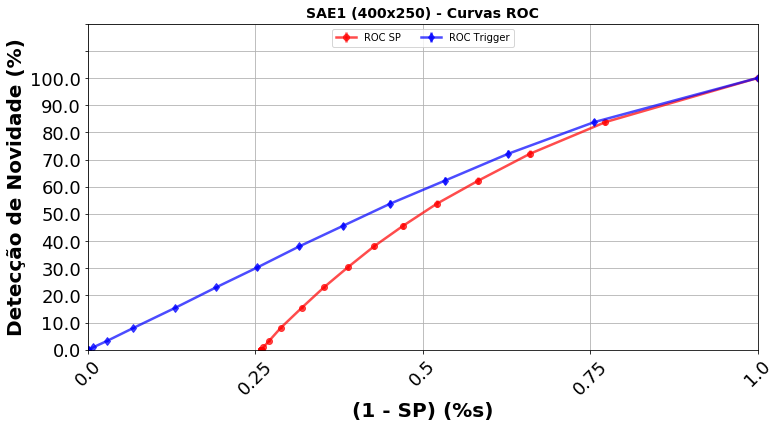

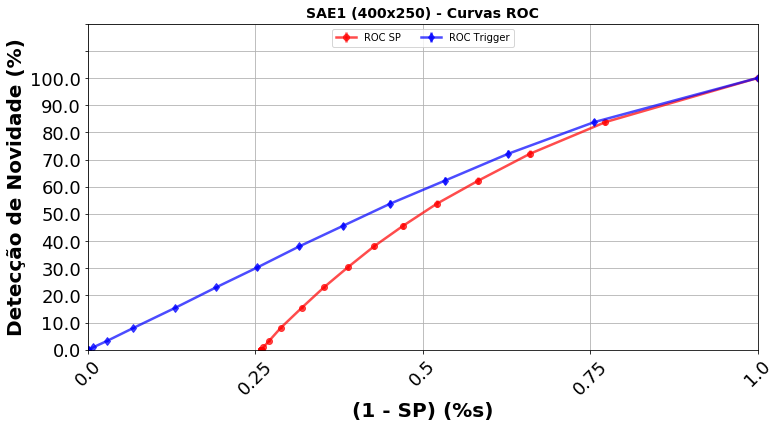

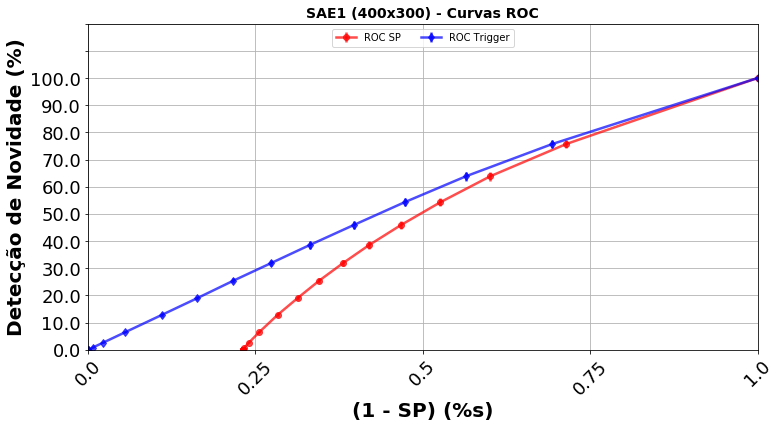

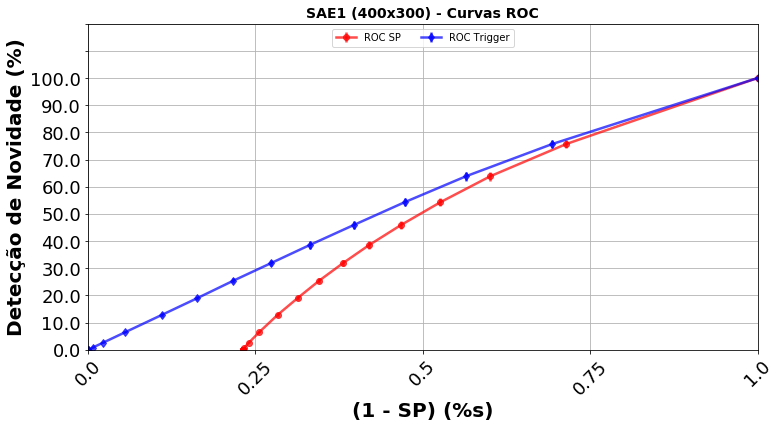

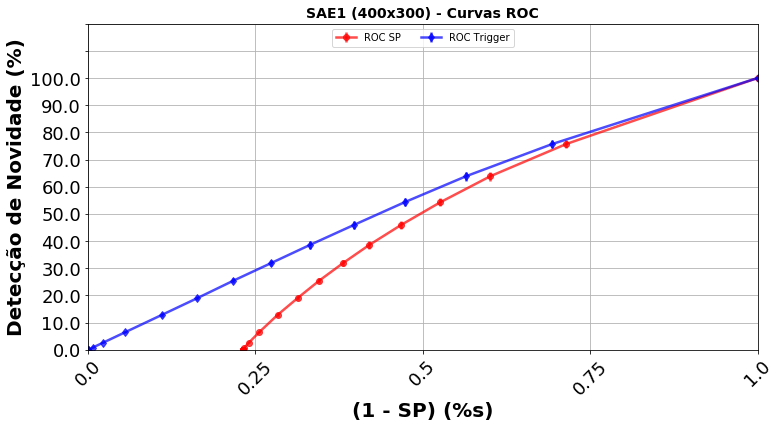

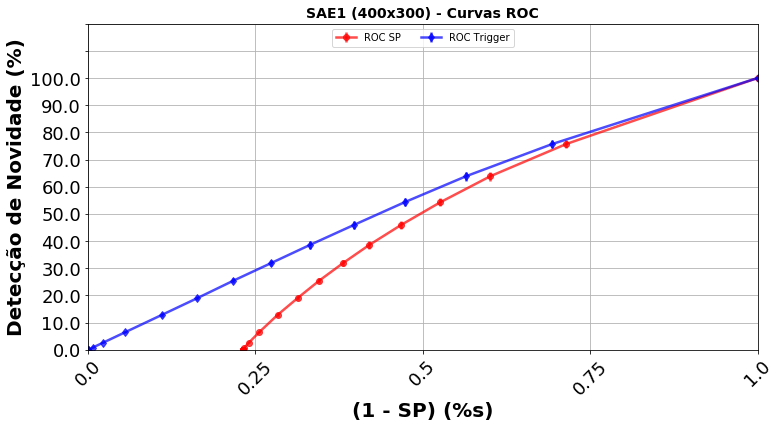

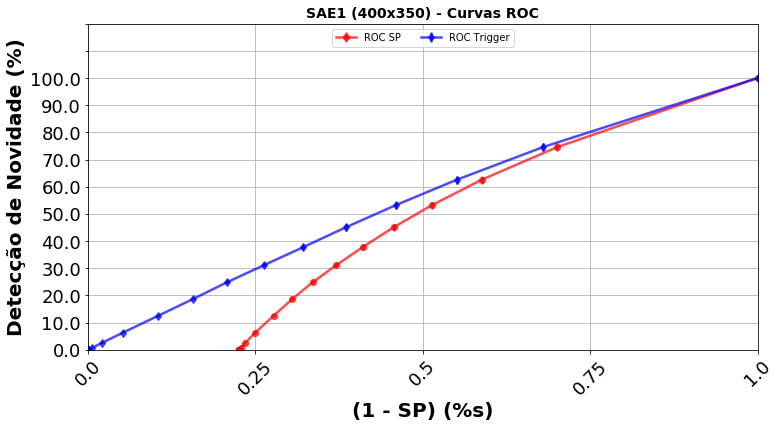

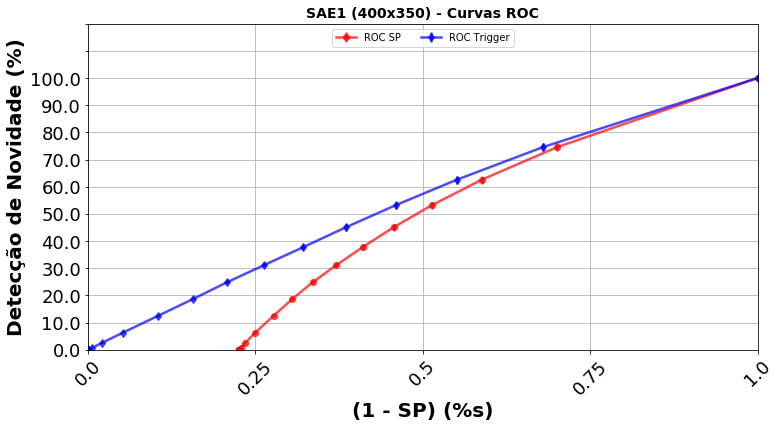

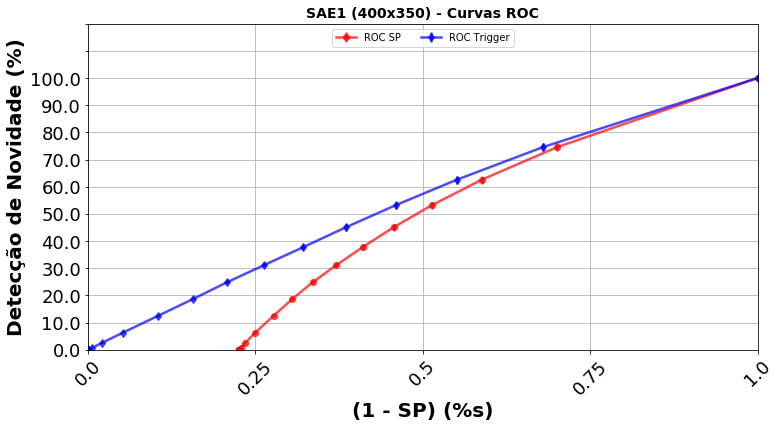

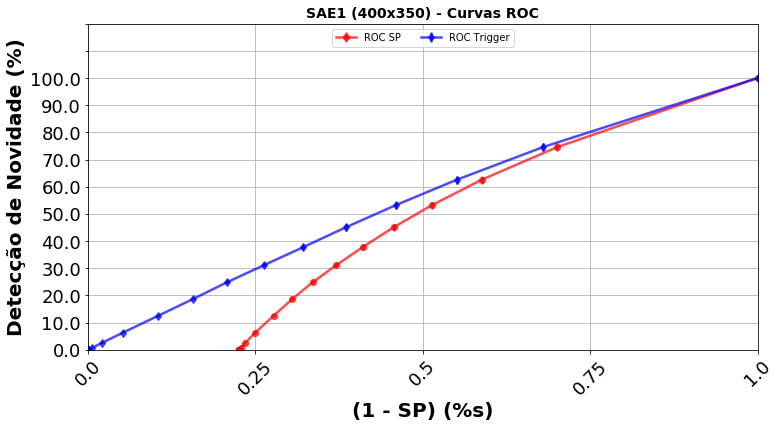

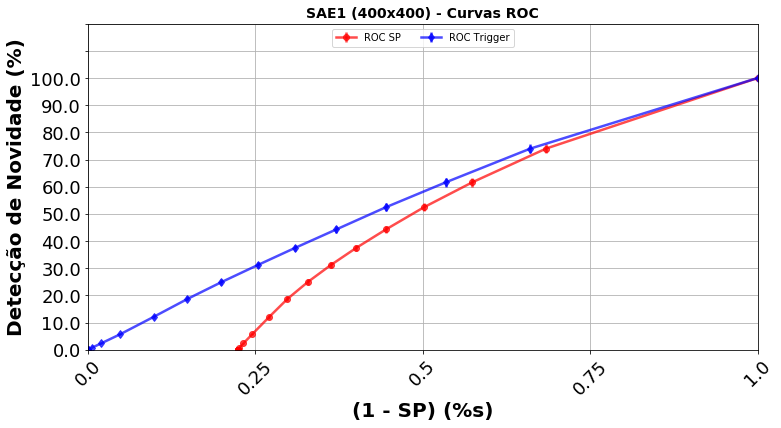

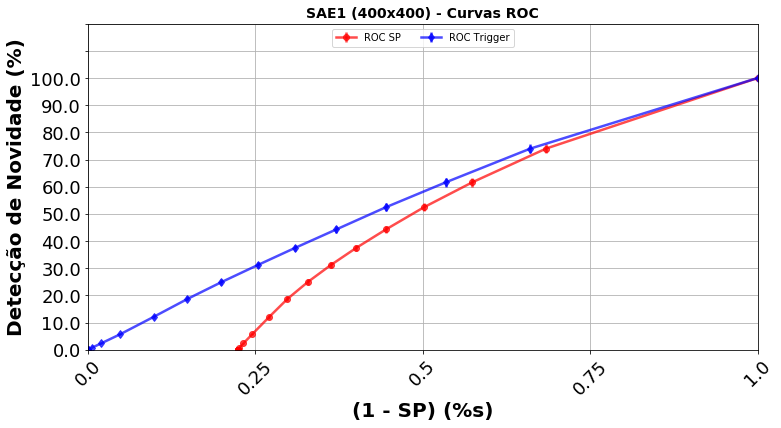

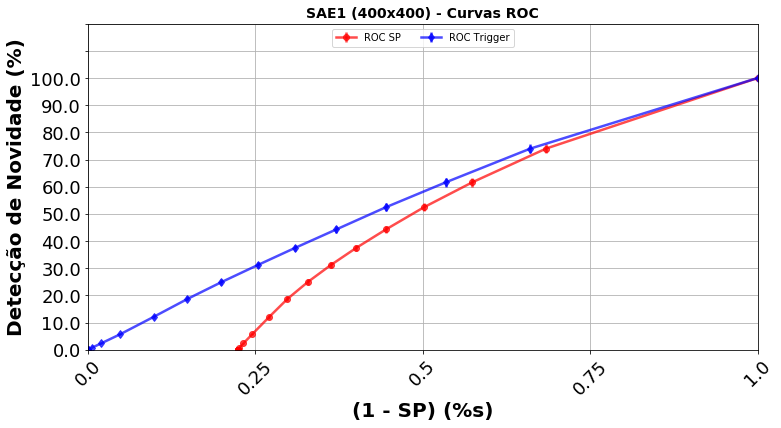

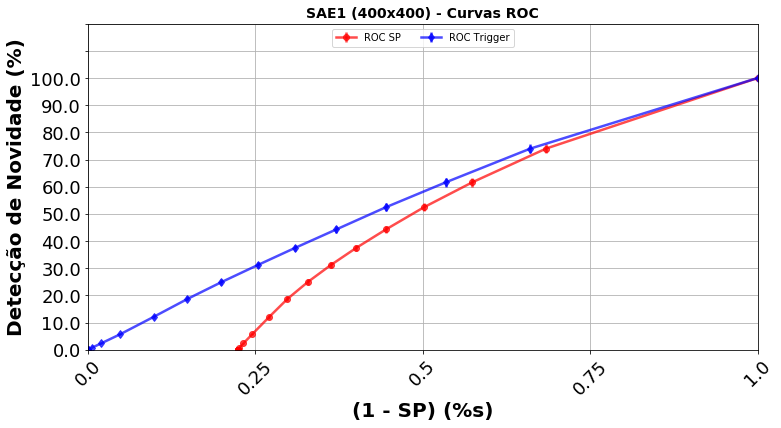

In [38]:
import pandas as pd

analysis_name = "fine_tuning_results_dataframe"
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".csv")  

if os.path.exists(analysis_file):
    results = pd.read_csv(analysis_file)
    neurons_mat = [1] + list(range(50,450,50))
    
    layer = 1
    for ineuron in neurons_mat:
        neurons_str = '400x{}'.format(ineuron)
        hidden_neurons = [ineuron]
        neurons_str = SAE[0].get_neurons_str(trn_data[0],hidden_neurons=hidden_neurons[:layer])
        language = 'portuguese'
        labels_text = {
                'portuguese': {
                    'threshold': 'Limiar',
                    'sp_index': 'Índice SP',
                    'accuracy': 'Acurácia',
                    'trigger': 'Trigger',
                    'novelty_detection': 'Det. Novidade',
                    'efficiency_A': 'Eficiência Classifi. Classe A', 
                    'efficiency_B': 'Eficiência Classifi. Classe B', 
                    'efficiency_C': 'Eficiência Classifi. Classe C',
                    'efficiency_D': 'Eficiência Classifi. Classe D'
                },
                'english': {
                    'threshold': 'Threshold',
                    'sp_index': 'SP Index',
                    'accuracy': 'Accuracy',
                    'trigger': 'Trigger',
                    'novelty_detection': 'Novelty Detection',
                    'efficiency_A': 'Efficiency Class A', 
                    'efficiency_B': 'Efficiency Class B', 
                    'efficiency_C': 'Efficiency Class C',
                    'efficiency_D': 'Efficiency Class D'
                }
        }

        plot_title = {
            'portuguese': 'SAE{0} ({1}) - Curvas ROC',
            'english': 'SAE{0} ({1})- ROC Curves'
        }

        plot_axes_labels = {
            'portuguese': {
                'x': 'AUC Relativo',
                'y': 'Classe Novidade'
            },
            'english': {
                'x': 'Relatiev AUC',
                'y': 'Novelty Class'
            }
        }

        
        for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
            results_plot = results.query("layers == {0} & topology == '{1}' & novelty_class == 'A'".format(layer, neurons_str, analysis.class_labels[inovelty]))
            
            fig = plt.subplots(figsize=(12,6))
            ax = plt.subplot(1,1,1)
            
            xdata1 = np.ones(results_plot.groupby(['threshold']).mean()['sp_index'].shape) - results_plot.groupby(['threshold']).mean()['sp_index']
            xdata2 = np.ones(results_plot.groupby(['threshold']).mean()['sp_index'].shape) - results_plot.groupby(['threshold']).mean()['trigger']


            ax.errorbar(xdata1, results_plot.groupby(['threshold']).mean()['novelty_detection'],
                        results_plot.groupby(['threshold']).std()['novelty_detection'],fmt='o-',
                        color='r',alpha=0.7,linewidth=2.5,
                        label='ROC SP')
            ax.errorbar(xdata2, results_plot.groupby(['threshold']).mean()['novelty_detection'],
                        results_plot.groupby(['threshold']).std()['novelty_detection'],fmt='d-',
                        color='b',alpha=0.7,linewidth=2.5,
                        label='ROC Trigger')
            ax.set_xticks(np.arange(0,1.25,0.25))
            ax.set_xticklabels(np.arange(0,1.25,0.25),rotation=45, fontsize=18)
            ax.set_title(plot_title[language].format(layer, neurons_str),
                        fontsize=14, fontweight='bold')
            
            ax.set_xlim([results_plot['threshold'].unique().min(), results_plot['threshold'].unique().max()])

            ax.set_ylim([0.0, 1.2])
            y_ticks = np.arange(0.0,1.3,0.1)
            ax.set_yticks(np.round(y_ticks,2))
            ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)

            ax.grid()

            ax.set_xlabel('(1 - SP) (%s)',fontsize=20,weight='bold')
            ax.set_ylabel('Detecção de Novidade (%)',fontsize=20,weight='bold')

            handles, labels = ax.get_legend_handles_labels()
            # sort both labels and handles by labels
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
            ax.legend(handles, labels, ncol=3, loc='upper center')

            plt.show()
            #Save the figure
        #     file_name = pict_results_path+'/'+"ROC_sp_novelty_det"+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
        #     plt.savefig(file_name)

In [95]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
from keras import losses
from keras import callbacks
from keras.layers.core import Dense, Activation, Dropout

inovelty = 1
ifold = 0
layer = 1

train_id, test_id = analysis.CVO[inovelty][ifold]
encoder = analysis.SAE[inovelty].get_stacked_encoder(data = trn_data[inovelty],
                                                     trgt  = trn_trgt[inovelty],
                                                     hidden_neurons=[400],
                                                     ifold = ifold,
                                                     layer = layer)



scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

norm_data = encoder.predict(scaler.transform(trn_data[inovelty]), batch_size=256)
novelty_data = scaler.transform(all_data[all_trgt==inovelty])

trgt_sparse = np_utils.to_categorical(trn_trgt[inovelty])

In [97]:
from keras import backend as K 

K.clear_session()

# Start the model
model = Sequential()

model.add(Dense(units=10, input_dim=norm_data.shape[1],
                bias_initializer=analysis.parameters["HyperParameters"]["bias_initializer"],
                kernel_initializer=analysis.parameters["HyperParameters"]["kernel_initializer"]))

model.add(Activation('tanh'))

# Add Output Layer
model.add(Dense(units=trgt_sparse.shape[1], 
                bias_initializer=analysis.parameters["HyperParameters"]["bias_initializer"],
                kernel_initializer=analysis.parameters["HyperParameters"]["kernel_initializer"]))
model.add(Activation('softmax'))

model.compile(loss='mean_squared_error',
              optimizer='nadam',
              metrics=['accuracy'])
# Train model
earlyStopping = callbacks.EarlyStopping(monitor=analysis.parameters["callbacks"]["EarlyStopping"]["monitor"],
                                        patience=analysis.parameters["callbacks"]["EarlyStopping"]["patience"],
                                        verbose=True,
                                        mode='auto')

init_trn_desc = model.fit(norm_data[train_id], trgt_sparse[train_id],
                          epochs=int(analysis.parameters["HyperParameters"]["finetuning_n_epochs"]), 
                          batch_size=analysis.parameters["HyperParameters"]["batch_size"],
                          callbacks=[earlyStopping],
                          verbose=True,
                          validation_data=(norm_data[test_id],
                                           trgt_sparse[test_id]),
                          shuffle=True
                          )

Train on 66042 samples, validate on 22014 samples
Epoch 1/300
66042/66042 [==============================] - 1s 19us/step - loss: 0.1305 - acc: 0.7519 - val_loss: 0.0830 - val_acc: 0.8297
Epoch 2/300
66042/66042 [==============================] - 1s 12us/step - loss: 0.0887 - acc: 0.8155 - val_loss: 0.0820 - val_acc: 0.8299
Epoch 3/300
66042/66042 [==============================] - 1s 11us/step - loss: 0.0859 - acc: 0.8211 - val_loss: 0.0815 - val_acc: 0.8311
Epoch 4/300
66042/66042 [==============================] - 1s 11us/step - loss: 0.0833 - acc: 0.8268 - val_loss: 0.0799 - val_acc: 0.8344
Epoch 5/300
66042/66042 [==============================] - 1s 11us/step - loss: 0.0808 - acc: 0.8340 - val_loss: 0.0787 - val_acc: 0.8388
Epoch 6/300
66042/66042 [==============================] - 1s 11us/step - loss: 0.0782 - acc: 0.8405 - val_loss: 0.0795 - val_acc: 0.8357
Epoch 7/300
66042/66042 [==============================] - 1s 11us/step - loss: 0.0755 - acc: 0.8472 - val_loss: 0.0782 - 

In [94]:
analysis.model_hash

'3aa7b6b2a784922c348292561edca3d5201d6d6567f727e6ce7e403d7f175b10'